## Get data in

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plotter
from pathlib import Path
import seaborn
from scipy.signal import *
from scipy.stats import probplot
from random import shuffle

In [2]:
data = Path("../data/summer_proc_data/")
files = list(data.iterdir())
print(files)

[PosixPath('../data/summer_proc_data/summer_proc_disk.csv'), PosixPath('../data/summer_proc_data/summer_proc_voltage.csv'), PosixPath('../data/summer_proc_data/summer_proc_power.csv'), PosixPath('../data/summer_proc_data/summer_proc_tx.csv'), PosixPath('../data/summer_proc_data/summer_proc_cpu.csv'), PosixPath('../data/summer_proc_data/summer_proc_rx.csv')]


In [3]:
disk = pandas.read_csv(str(data/"summer_proc_disk.csv")).drop("Unnamed: 0", axis=1)
cpu = pandas.read_csv(str(data/"summer_proc_cpu.csv")).drop("Unnamed: 0", axis=1)
power = pandas.read_csv(str(data/"summer_proc_power.csv")).drop("Unnamed: 0", axis=1)
tx = pandas.read_csv(str(data/"summer_proc_tx.csv")).drop("Unnamed: 0", axis=1)
rx = pandas.read_csv(str(data/"summer_proc_rx.csv")).drop("Unnamed: 0", axis=1)

In [4]:
power = power.drop("Time", axis=1)
#power = medfilt(power.as_matrix().ravel(), 21)
power = pandas.DataFrame(power.as_matrix().ravel(), columns=["power"])
power.head()

,power
0,1450.609756
1,1450.609756
2,1331.707317
3,1427.642276
4,1384.756098


In [5]:
cpu.describe()

,CPU_user
count,34560.000000
mean,396.757533
std,337.801514
min,5.000000
25%,13.000000
50%,436.000000
75%,544.166667
max,1202.166667


In [6]:
disk.describe()

,disk_p2
count,34560.000000
mean,229.147859
std,486.386083
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3900.000000


In [7]:
tx.describe()

,net_TX
count,34560.000000
mean,76.361343
std,58.354279
min,12.000000
25%,15.000000
50%,78.000000
75%,97.500000
max,251.000000


------

## Clip data within limits

In [8]:
all_data = pandas.concat([cpu, tx, rx, disk, power], axis=1, join="inner").drop("Time", axis=1).fillna(0)
all_data.describe()

,CPU_user,net_TX,net_RX,disk_p2,power
count,34560.000000,34560.000000,34560.000000,34560.000000,34560.000000
mean,396.757533,76.361343,9.475424,229.147859,1604.634287
std,337.801514,58.354279,1.213157,486.386083,202.190383
min,5.000000,12.000000,8.000000,0.000000,1276.829268
25%,13.000000,15.000000,8.000000,0.000000,1407.926829
50%,436.000000,78.000000,10.000000,0.000000,1619.715447
75%,544.166667,97.500000,10.000000,0.000000,1716.463415
max,1202.166667,251.000000,52.666667,3900.000000,2455.487805


In [9]:
all_data.head()

,CPU_user,net_TX,net_RX,disk_p2,power
0,10.0,78.0,8.0,0.0,1450.609756
1,10.0,78.0,8.0,0.0,1450.609756
2,8.0,111.0,8.0,0.0,1331.707317
3,12.0,97.5,10.0,0.0,1427.642276
4,9.5,97.5,10.0,0.0,1384.756098


## Recale Data between 0 and 1

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
sscaler = StandardScaler()
columns = list(map(lambda x: x.split()[-1], all_data.columns))

all_data = pandas.DataFrame(scaler.fit_transform(all_data.as_matrix()), columns=columns)

all_data.head(5)

,CPU_user,net_TX,net_RX,disk_p2,power
0,0.004177,0.276151,0.000000,0.0,0.147439
1,0.004177,0.276151,0.000000,0.0,0.147439
2,0.002506,0.414226,0.000000,0.0,0.046560
3,0.005847,0.357741,0.044776,0.0,0.127953
4,0.003759,0.357741,0.044776,0.0,0.091568


## Write Data loaders

In [11]:
class DataLoader:
    """
        Defines data loader for seq2point model.
    """
    
    def __init__(self, X, y, window=5):
        self.X = X
        self.y = y
        self.window = window
        
    def __len__(self):
        return (self.X.shape[0]-(self.window+1))
    
    def __getitem__(self, i):
        """
            Returns single batch of data in flat seq2point compatible format.
        """
        X = self.X[i: i+self.window]
        cpu_y = self.y.iloc[i+int(self.window/2)]["CPU_user"]
        tx_y = self.y.iloc[i+int(self.window/2)]["net_TX"]
        rx_y = self.y.iloc[i+int(self.window/2)]["net_RX"]
        disk_y = self.y.iloc[i+int(self.window/2)]["disk_p2"]
        
        return (X, {"cpu": cpu_y, "tx": tx_y, "rx": rx_y, "disk": disk_y})


class BatchLoader:
    """
        Creates batches from data provided by dataloader.
    """
    
    def __init__(self, dataloader, batch_size=32, random=False):
        self.dloader = dataloader
        self.batch_size = batch_size
        self.samples = list(range(len(self.dloader)))
        self.random = random
        
    def __len__(self):
        return int(len(self.dloader)/self.batch_size) - 1
        
    def __getitem__(self, i):
        i = i*self.batch_size
        _samples = self.samples[i: i+self.batch_size]
        
        if self.random:
            shuffle(_samples)
        
        X=[]
        y=[]
        
        for j in range(len(_samples)):
            _X, _y = self.dloader[_samples[j]]
            X.append(_X.ravel())
            y.append(_y)
        
        return numpy.array(X), numpy.array(y)

In [12]:
class ConvBatchLoader:
    """
        Creates conv batches from data provided by dataloader.
    """
    
    def __init__(self, dataloader, batch_size=32):
        self.dloader = dataloader
        self.batch_size = batch_size
        self.samples = list(range(len(self.dloader)))
        
    def __len__(self):
        return int(len(self.dloader)/self.batch_size) - 1
        
    def __getitem__(self, i):
        i = i*self.batch_size
        _samples = self.samples[i: i+self.batch_size]
        
        X=[]
        cpu_y=[]
        rx_y=[]
        tx_y=[]
        disk_y=[]
        
        for j in range(len(_samples)):
            _X, _y = self.dloader[_samples[j]]
            X.append(_X)
            cpu_y.append(_y["cpu"])
            rx_y.append(_y["rx"])
            tx_y.append(_y["tx"])
            disk_y.append(_y["disk"])
        
        return numpy.array(X), {"cpu": numpy.array(cpu_y), "tx": numpy.array(tx_y), "rx": numpy.array(rx_y), "disk": numpy.array(disk_y)}

## Train linear model

In [13]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error

In [14]:
from keras.layers import Conv1D, Input, Dense, Flatten, MaxPooling1D, LSTM, Concatenate, Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error
from keras.utils import plot_model

/home/adityas/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Predict CPU IDLE

In [15]:
loader = ConvBatchLoader(dataloader=DataLoader(X=all_data["power"].as_matrix()[:20000, numpy.newaxis], y=all_data[:20000], window=51), batch_size=64)

In [16]:
_input = Input(shape=(51, 1))
conv = Conv1D(kernel_size=10, filters=40, activation="relu")(_input)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Conv1D(kernel_size=10, filters=40, activation="relu")(conv)

#CPU
cpu_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(conv)
cpu_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(cpu_conv)
cpu_flat = Flatten()(cpu_conv)
cpu_out = Dense(1, activation="sigmoid", name="cpu")(cpu_flat)

#TX
tx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(conv)
tx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(tx_conv)
tx_flat = Flatten()(tx_conv)
tx_out = Dense(1, activation="sigmoid", name="tx")(tx_flat)

#RX
rx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(conv)
rx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(rx_conv)
rx_flat = Flatten()(rx_conv)
rx_out = Dense(1, activation="sigmoid", name="rx")(rx_flat)

#Disk
disk_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(conv)
disk_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disk_conv)
disk_flat = Flatten()(disk_conv)
disk_out = Dense(1, activation="sigmoid", name="disk")(disk_flat)

In [17]:
model = Model(inputs=_input, outputs=[cpu_out, tx_out, rx_out, disk_out])
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

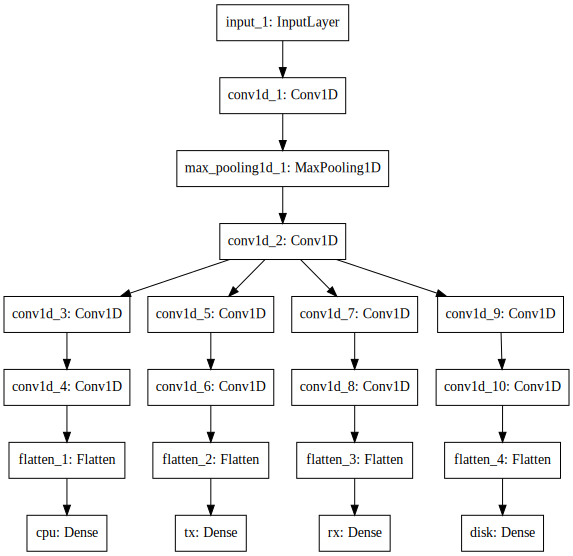

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
def data_gen():
    while 1:
        for i in range(len(loader)):
            yield loader[i]

In [20]:
val_loader = ConvBatchLoader(dataloader=DataLoader(X=all_data["power"].as_matrix()[20000:25000, numpy.newaxis], y=all_data[20000:25000], window=51), batch_size=5000)
_data_gen = data_gen()
val_data = val_loader[0]
estopper = EarlyStopping(monitor="val_loss", patience=10)
#sch = ReduceLROnPlateau(factor=0.1, min_lr=0.00001, patience=5)
model.fit_generator(callbacks=[estopper], generator=_data_gen, validation_data=val_data, shuffle=True, steps_per_epoch=500, epochs=100, verbose=2)

Epoch 1/100
 - 15s - loss: 0.0925 - cpu_loss: 0.0381 - tx_loss: 0.0253 - rx_loss: 0.0081 - disk_loss: 0.0210 - cpu_mean_absolute_error: 0.1400 - tx_mean_absolute_error: 0.1272 - rx_mean_absolute_error: 0.0443 - disk_mean_absolute_error: 0.0819 - val_loss: 0.0361 - val_cpu_loss: 0.0102 - val_tx_loss: 0.0166 - val_rx_loss: 7.9926e-04 - val_disk_loss: 0.0085 - val_cpu_mean_absolute_error: 0.0808 - val_tx_mean_absolute_error: 0.1017 - val_rx_mean_absolute_error: 0.0232 - val_disk_mean_absolute_error: 0.0554
Epoch 2/100
 - 13s - loss: 0.0314 - cpu_loss: 0.0085 - tx_loss: 0.0152 - rx_loss: 8.9669e-04 - disk_loss: 0.0068 - cpu_mean_absolute_error: 0.0717 - tx_mean_absolute_error: 0.0929 - rx_mean_absolute_error: 0.0221 - disk_mean_absolute_error: 0.0507 - val_loss: 0.0268 - val_cpu_loss: 0.0078 - val_tx_loss: 0.0125 - val_rx_loss: 6.9988e-04 - val_disk_loss: 0.0058 - val_cpu_mean_absolute_error: 0.0674 - val_tx_mean_absolute_error: 0.0810 - val_rx_mean_absolute_error: 0.0203 - val_disk_mean_a

In [21]:
def run_thresholding(data):
        arr = pandas.Series(data)
        mean = 0
        count = 0
        outliers = numpy.zeros_like(arr)
        thres = numpy.zeros_like(arr)
        means = numpy.zeros_like(arr)
        cmeans = arr.expanding().mean()
        std = 0

        # Compute running stats

        m2 = 0
        for i in range(len(arr)):

            if i > 100 and arr[i] > (mean + 3 * std):
                outliers[i] = data[i]
                means[i] = mean
                thres[i] = mean + (3 * std)
                continue

            count = count + 1
            delta = arr[i] - mean

            mean = mean + (delta/count)
            means[i] = mean

            new_delta = arr[i] - mean
            m2 = m2 + delta * new_delta

            std = numpy.sqrt(m2 / count)

            thres[i] = mean + (3 * std)
            
        return thres, outliers

In [22]:
bloader = ConvBatchLoader(dataloader=DataLoader(X=all_data["power"].as_matrix()[30000:, numpy.newaxis], y=all_data[30000:], window=51), batch_size=5000)

In [23]:
X, y = bloader[0]
prediction = model.predict(X)
cpu_pred = prediction[0]
tx_pred = prediction[1]
rx_pred = prediction[2]
disk_pred = prediction[3]

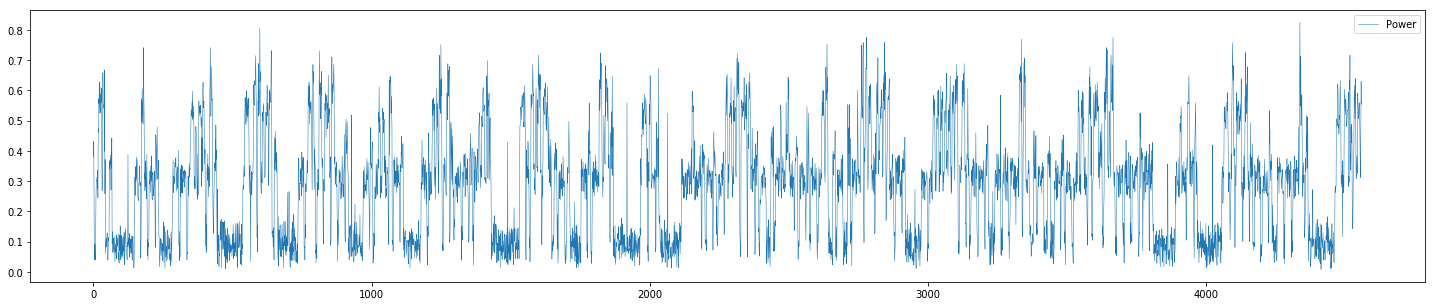

CPU


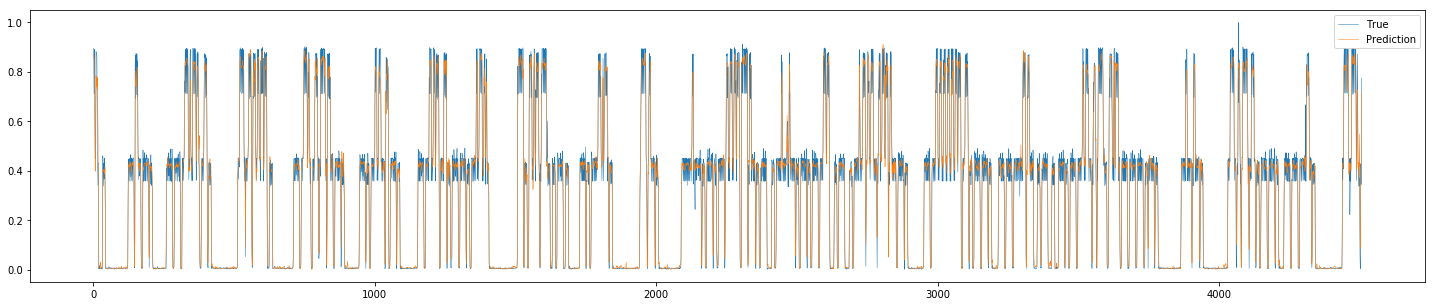

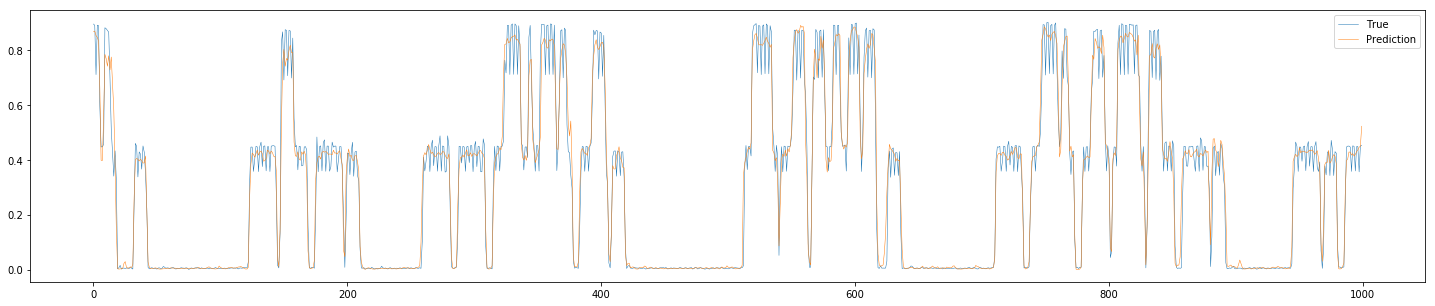

TX


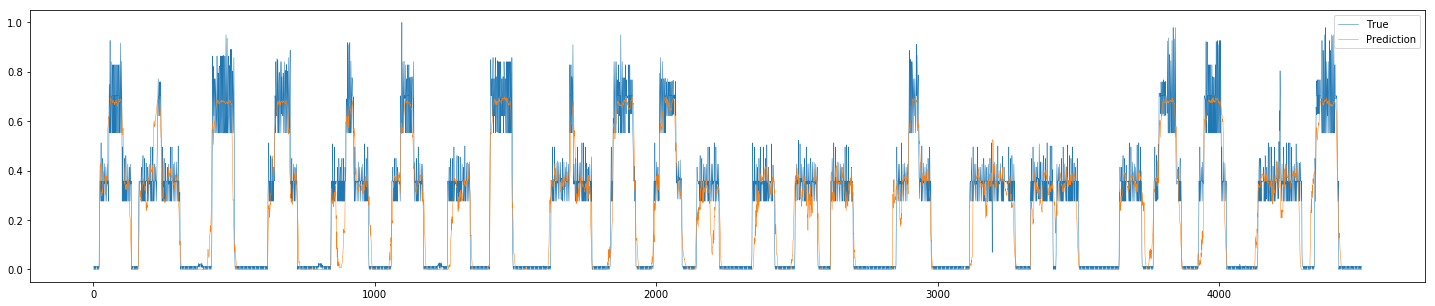

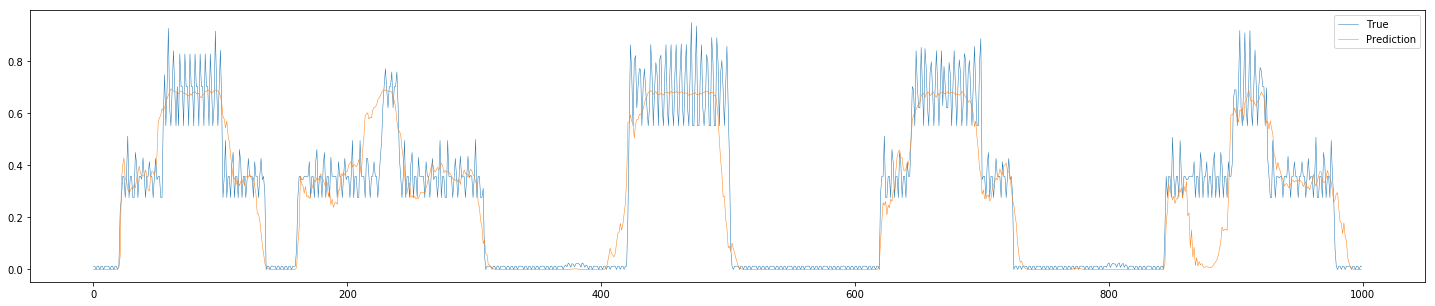

RX


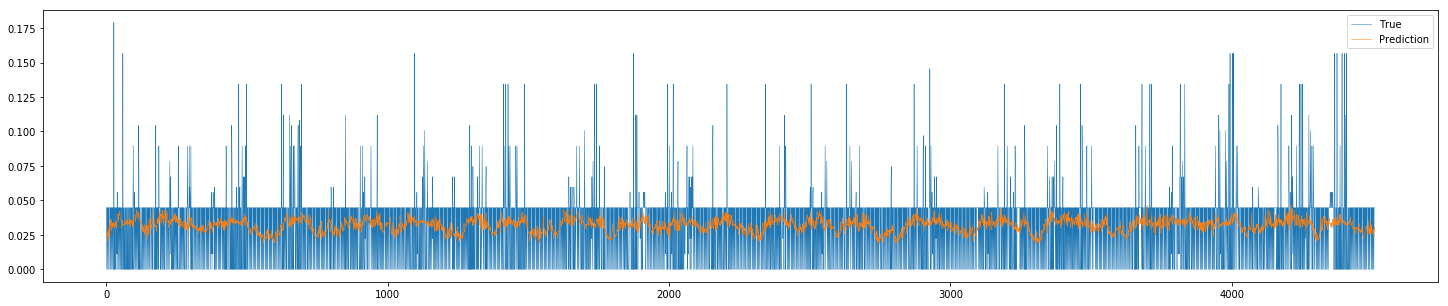

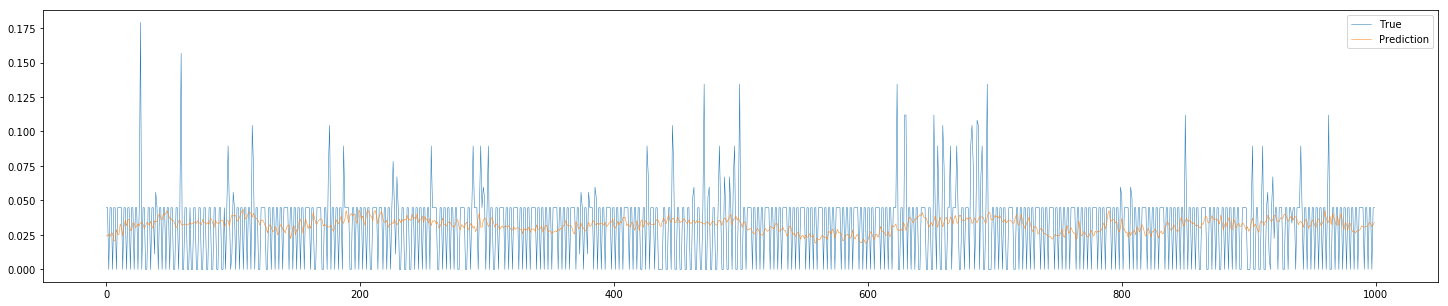

Disk


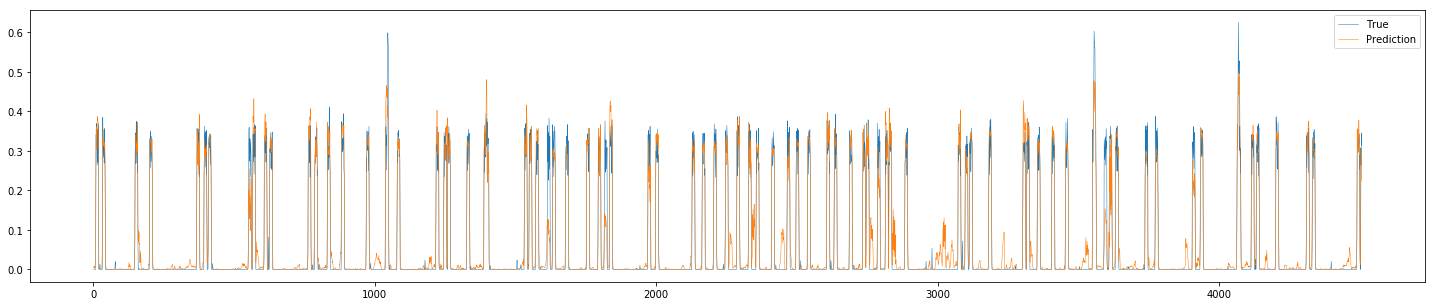

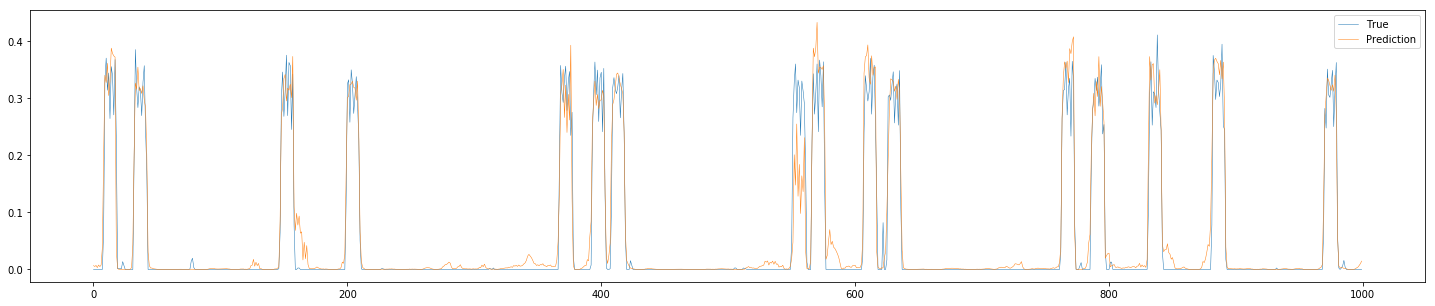

In [24]:
fig = plotter.figure(figsize=(25,5))
plotter.plot(all_data["power"].as_matrix()[30000:, numpy.newaxis], linewidth=0.5, label="Power")
plotter.legend()
plotter.show()

#CPU
print("CPU")
fig = plotter.figure(figsize=(25,5))
plotter.plot(y["cpu"], linewidth=0.5, label="True")
plotter.plot(cpu_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

fig = plotter.figure(figsize=(25,5))
plotter.plot(y["cpu"][:1000], linewidth=0.5, label="True")
plotter.plot(cpu_pred[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

#TX
print("TX")
fig = plotter.figure(figsize=(25,5))
plotter.plot(y["tx"], linewidth=0.5, label="True")
plotter.plot(tx_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

fig = plotter.figure(figsize=(25,5))
plotter.plot(y["tx"][:1000], linewidth=0.5, label="True")
plotter.plot(tx_pred[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

#RX
print("RX")
fig = plotter.figure(figsize=(25,5))
plotter.plot(y["rx"], linewidth=0.5, label="True")
plotter.plot(rx_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

fig = plotter.figure(figsize=(25,5))
plotter.plot(y["rx"][:1000], linewidth=0.5, label="True")
plotter.plot(rx_pred[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

#DIsk
print("Disk")
fig = plotter.figure(figsize=(25,5))
plotter.plot(y["disk"], linewidth=0.5, label="True")
plotter.plot(disk_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

fig = plotter.figure(figsize=(25,5))
plotter.plot(y["disk"][:1000], linewidth=0.5, label="True")
plotter.plot(disk_pred[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

## Make test set

In [25]:
data = Path("../data/summer_proc_test/")
files = list(data.iterdir())
print(files)

[PosixPath('../data/summer_proc_test/summer_proc_test_cpu.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_tx.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_rx.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_voltage.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_power.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_disk.csv')]


In [26]:
disk = pandas.read_csv(str(data/"summer_proc_test_disk.csv")).drop("Unnamed: 0", axis=1)
cpu = pandas.read_csv(str(data/"summer_proc_test_cpu.csv")).drop("Unnamed: 0", axis=1)
power = pandas.read_csv(str(data/"summer_proc_test_power.csv")).drop("Unnamed: 0", axis=1).fillna(0)
tx = pandas.read_csv(str(data/"summer_proc_test_tx.csv")).drop("Unnamed: 0", axis=1)
rx = pandas.read_csv(str(data/"summer_proc_test_rx.csv")).drop("Unnamed: 0", axis=1)

In [27]:
power = power.drop("Time", axis=1)
power = pandas.DataFrame(power.as_matrix().ravel(), columns=["power"])
power.head()

,power
0,1381.097561
1,1381.097561
2,1591.056911
3,1598.170732
4,1591.463415


In [28]:
test_data = pandas.concat([cpu, tx, rx, disk, power], axis=1, join="inner").drop("Time", axis=1).fillna(0)
test_data.describe()

,CPU_user,net_TX,net_RX,disk_p2,power
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,503.303935,264.406250,211.630556,222.303241,1804.014651
std,399.552048,599.688124,606.191497,484.812885,332.300303
min,6.000000,12.000000,8.000000,0.000000,1286.585366
25%,13.666667,15.000000,8.000000,0.000000,1504.878049
50%,524.750000,20.000000,10.000000,0.000000,1784.756098
75%,879.875000,144.000000,10.500000,3.333333,2008.180894
max,1126.500000,2676.500000,2672.500000,3405.000000,2684.146341


In [29]:
columns = test_data.columns

test_data = pandas.DataFrame(scaler.transform(test_data.as_matrix()), columns=columns)

In [25]:
data = Path("../data/summer_proc_test/")
files = list(data.iterdir())
print(files)

[PosixPath('../data/summer_proc_test/summer_proc_test_cpu.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_tx.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_rx.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_voltage.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_power.csv'), PosixPath('../data/summer_proc_test/summer_proc_test_disk.csv')]


In [26]:
disk = pandas.read_csv(str(data/"summer_proc_test_disk.csv")).drop("Unnamed: 0", axis=1)
cpu = pandas.read_csv(str(data/"summer_proc_test_cpu.csv")).drop("Unnamed: 0", axis=1)
power = pandas.read_csv(str(data/"summer_proc_test_power.csv")).drop("Unnamed: 0", axis=1).fillna(0)
tx = pandas.read_csv(str(data/"summer_proc_test_tx.csv")).drop("Unnamed: 0", axis=1)
rx = pandas.read_csv(str(data/"summer_proc_test_rx.csv")).drop("Unnamed: 0", axis=1)

In [27]:
power = power.drop("Time", axis=1)
power = pandas.DataFrame(power.as_matrix().ravel(), columns=["power"])
power.head()

,power
0,1381.097561
1,1381.097561
2,1591.056911
3,1598.170732
4,1591.463415


In [28]:
test_data = pandas.concat([cpu, tx, rx, disk, power], axis=1, join="inner").drop("Time", axis=1).fillna(0)
test_data.describe()

,CPU_user,net_TX,net_RX,disk_p2,power
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,503.303935,264.406250,211.630556,222.303241,1804.014651
std,399.552048,599.688124,606.191497,484.812885,332.300303
min,6.000000,12.000000,8.000000,0.000000,1286.585366
25%,13.666667,15.000000,8.000000,0.000000,1504.878049
50%,524.750000,20.000000,10.000000,0.000000,1784.756098
75%,879.875000,144.000000,10.500000,3.333333,2008.180894
max,1126.500000,2676.500000,2672.500000,3405.000000,2684.146341


In [29]:
columns = test_data.columns

test_data = pandas.DataFrame(scaler.transform(test_data.as_matrix()), columns=columns)

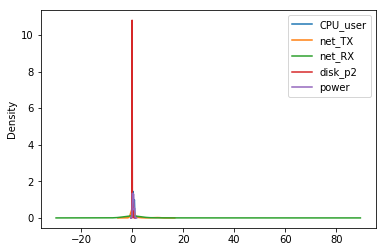

In [30]:
test_data.plot(kind="density")
plotter.show()

In [31]:
bloader = ConvBatchLoader(dataloader=DataLoader(X=test_data["power"][:, numpy.newaxis], y=test_data, window=51), batch_size=4000)

In [32]:
#bloader = ConvBatchLoader(dataloader=DataLoader(X=all_data["power"].as_matrix()[30000:, numpy.newaxis], y=all_data[30000:], window=51), batch_size=5000)

In [33]:
X, y = bloader[0]
prediction = model.predict(X)
cpu_pred = prediction[0]
tx_pred = prediction[1]
rx_pred = prediction[2]
disk_pred = prediction[3]

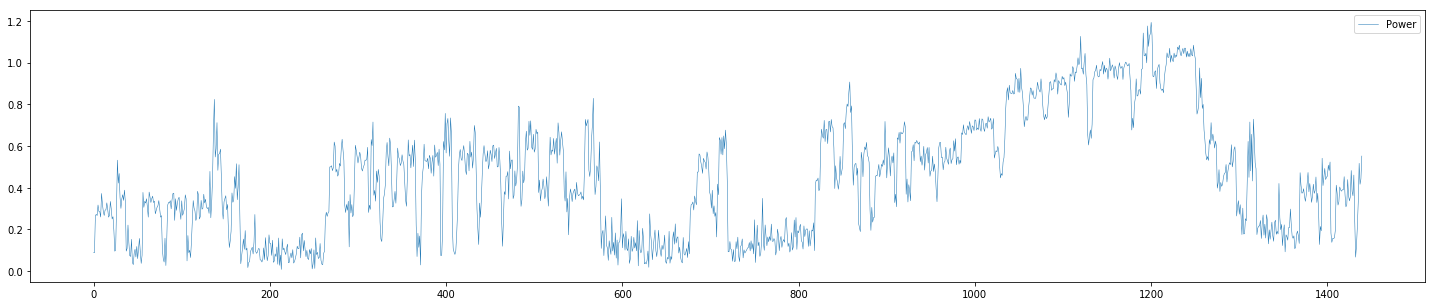

CPU


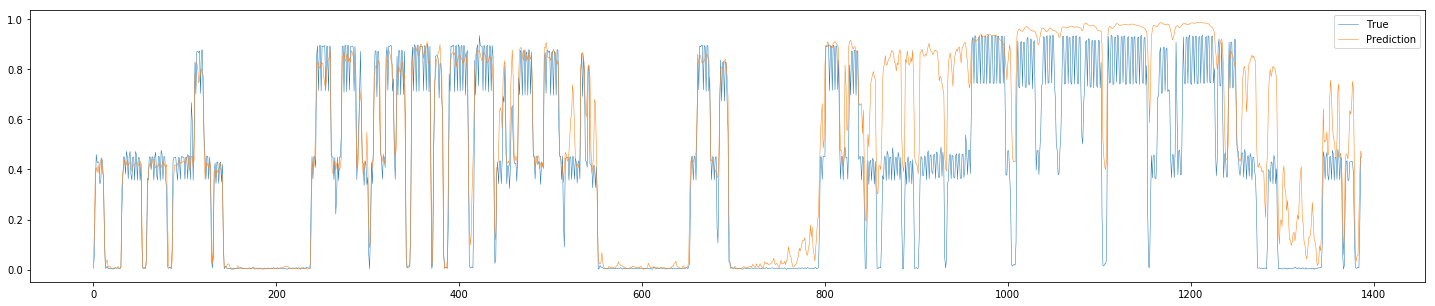

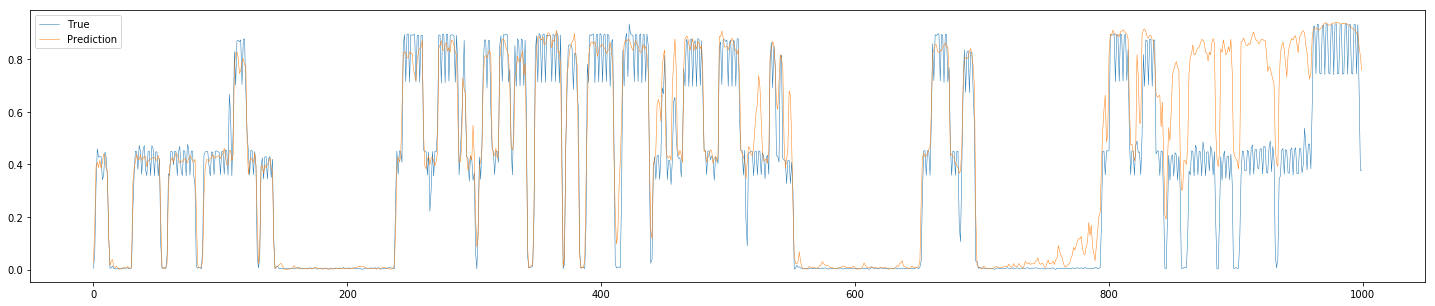

TX


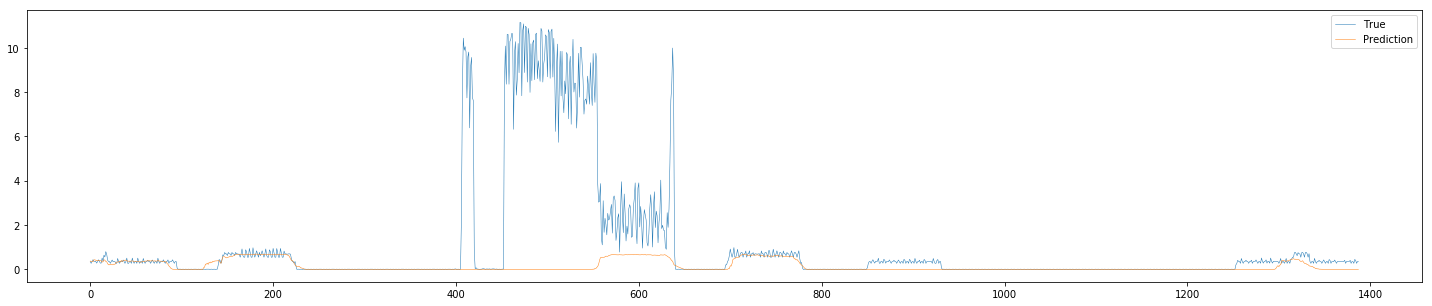

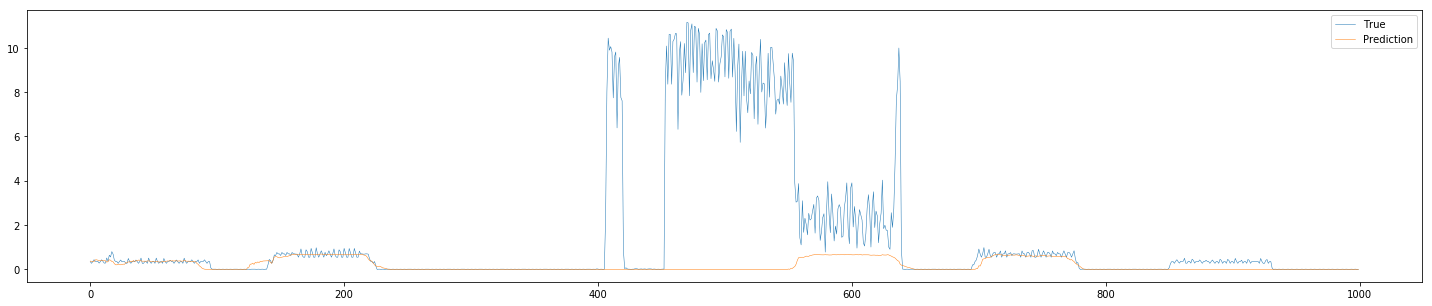

RX


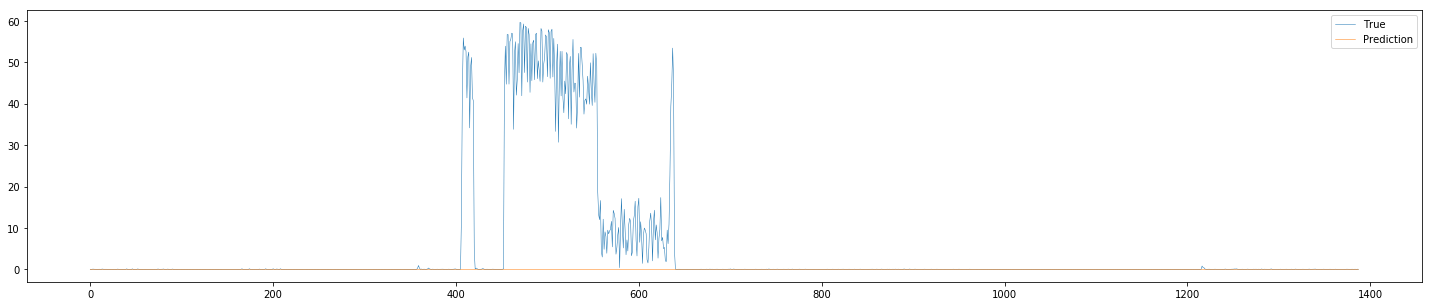

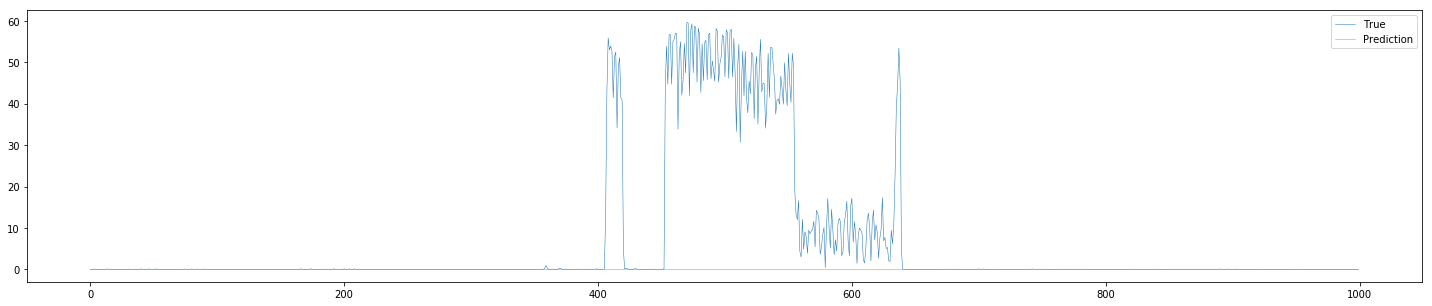

Disk


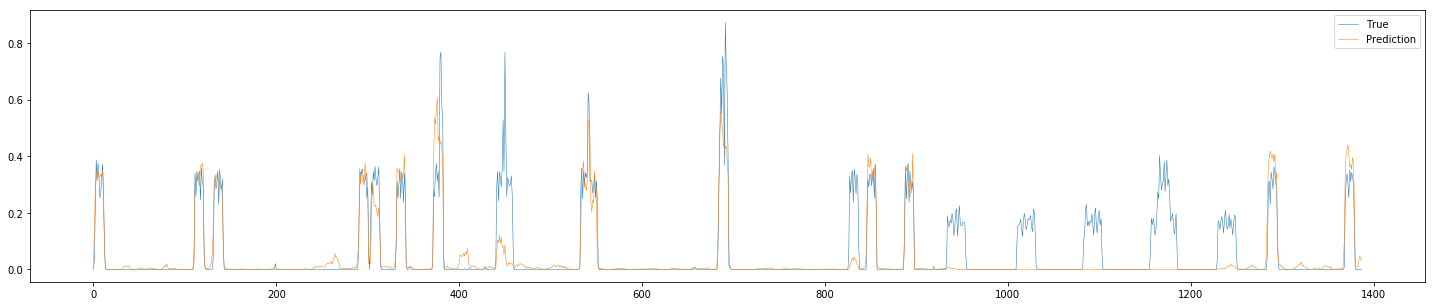

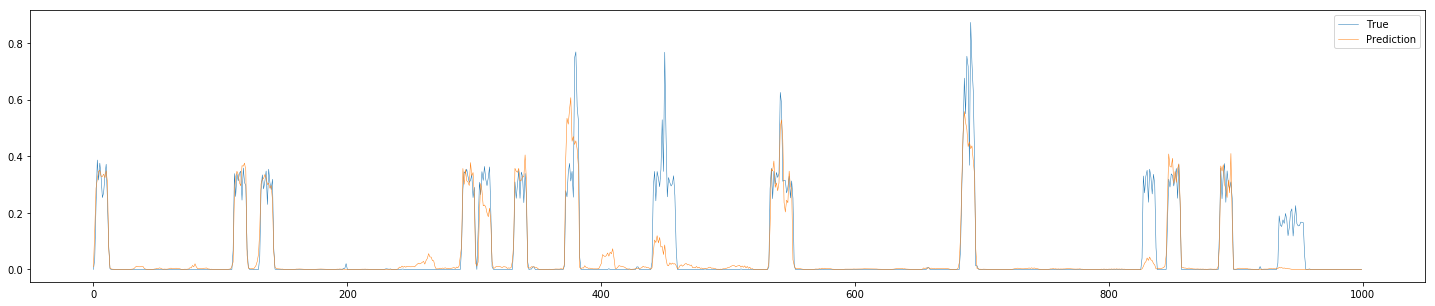

In [34]:
fig = plotter.figure(figsize=(25,5))
plotter.plot(test_data["power"].as_matrix(), linewidth=0.5, label="Power")
plotter.legend()
plotter.show()

#CPU
print("CPU")
fig = plotter.figure(figsize=(25,5))
plotter.plot(y["cpu"], linewidth=0.5, label="True")
plotter.plot(cpu_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

fig = plotter.figure(figsize=(25,5))
plotter.plot(y["cpu"][:1000], linewidth=0.5, label="True")
plotter.plot(cpu_pred[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

#TX
print("TX")
fig = plotter.figure(figsize=(25,5))
plotter.plot(y["tx"], linewidth=0.5, label="True")
plotter.plot(tx_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

fig = plotter.figure(figsize=(25,5))
plotter.plot(y["tx"][:1000], linewidth=0.5, label="True")
plotter.plot(tx_pred[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

#RX
print("RX")
fig = plotter.figure(figsize=(25,5))
plotter.plot(y["rx"], linewidth=0.5, label="True")
plotter.plot(rx_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

fig = plotter.figure(figsize=(25,5))
plotter.plot(y["rx"][:1000], linewidth=0.5, label="True")
plotter.plot(rx_pred[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

#DIsk
print("Disk")
fig = plotter.figure(figsize=(25,5))
plotter.plot(y["disk"], linewidth=0.5, label="True")
plotter.plot(disk_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

fig = plotter.figure(figsize=(25,5))
plotter.plot(y["disk"][:1000], linewidth=0.5, label="True")
plotter.plot(disk_pred[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()